In [ ]:
%pip install --force-reinstall -v "tensorflow==2.19"
%pip install pandas keras keras_tuner

In [ ]:
%pip install matplotlib seaborn scikit-learn
%pip install mlflow

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers


mlflow.set_experiment("classification_experiments")
import matplotlib.pyplot as plt



In [2]:
input_file_path = "FootballPlayerPreparedCleanAttributes.csv"
output_file_path = "FootballPlayerOneHotEncodedClasses.csv"
input_dataframe = pd.read_csv(input_file_path)
output_dataframe = pd.read_csv(output_file_path)

In [3]:
seed_1 = 42
seed_2 = 24

train_x = input_dataframe.sample(frac = 0.8, random_state=seed_1)
test_temp_x = input_dataframe.drop(train_x.index)
test_x = test_temp_x.sample(frac = 0.5, random_state=seed_2)
validate_x = test_temp_x.drop(test_x.index)

train_y = output_dataframe.loc[train_x.index]
test_y = output_dataframe.loc[test_x.index]
validate_y = output_dataframe.loc[validate_x.index]


In [4]:
train_x.shape

(12907, 22)

RUN MODEL AND STORE IN ML FLOW

In [5]:
# According to Lecture 12 - Backprop & Improving Neural Networks | Stanford CS229: Machine Learning (Autumn 2018)
# This is the best initialization for sigmoid activation function
# they also mention to use same activation function for all layers and that Sigmoid is best for our case - choose between 0 and 1
def custom_sigmoid_initializer(shape, dtype=None): 
    n_in = shape[0]  # number of inputs to the layer
    limit = tf.sqrt(1.0 / n_in)
    return tf.random.uniform(shape, minval=-limit, maxval=limit, dtype=dtype)

Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2918 - loss: 1.3972 - val_accuracy: 0.5750 - val_loss: 0.9170
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6312 - loss: 0.7979 - val_accuracy: 0.6611 - val_loss: 0.7210
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6665 - loss: 0.7365 - val_accuracy: 0.6561 - val_loss: 0.7173
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6734 - loss: 0.7188 - val_accuracy: 0.6890 - val_loss: 0.6709
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6791 - loss: 0.6988 - val_accuracy: 0.6927 - val_loss: 0.6660
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6946 - loss: 0.6779 - val_accuracy: 0.7299 - val_loss: 0.6082
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7222 - loss: 0.6106 - val_accuracy: 0.7311 - val_loss: 0.5951
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7570 - loss: 0.5439 - val_a

2025/10/16 11:05:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 11:05:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/16 11:05:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/t2/d3hrzr8x7zd9cnztszgjcw0h0000gn/T/tmpiuvdfgoq/model, flavor: keras). Fall back to return ['keras==3.11.3']. Set logging level to DEBUG to see the full traceback. 
2025/10/16 11:05:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


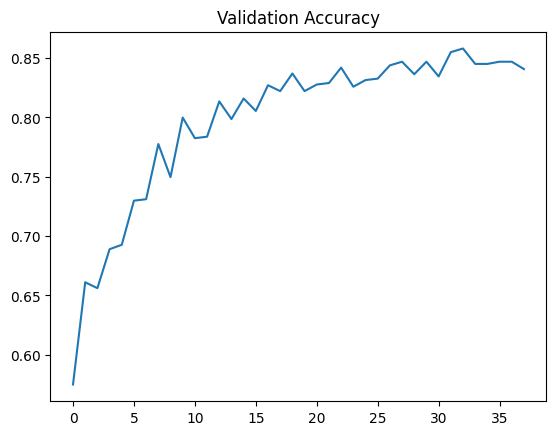

In [6]:

with mlflow.start_run(run_name=f"1000 Sigmoid, custom init, 0.15 dropout, 32 batch, 50 epochs") as run:
    
    # Log hyperparameters
    mlflow.log_param("activation", "sigmoid")
    mlflow.log_param("dropout_rate", 0)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 50)
    
    # Define the model
    model = keras.Sequential([
            layers.Input(shape=(22,)),

            layers.Dense(1000, activation='sigmoid', kernel_initializer=custom_sigmoid_initializer),
            layers.Dropout(0.15),

            layers.Dense(1000, activation='sigmoid', kernel_initializer=custom_sigmoid_initializer),
            layers.Dropout(0.15),

            layers.Dense(1000, activation='sigmoid', kernel_initializer=custom_sigmoid_initializer),
            layers.Dropout(0.15),

            layers.Dense(1000, activation='sigmoid', kernel_initializer=custom_sigmoid_initializer),
            layers.Dropout(0.15),

            layers.Dense(4, activation='softmax', kernel_initializer='glorot_uniform')  # output layer
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_x, train_y,
        validation_data=(test_x, test_y),
        epochs=50,
        batch_size=32,
        verbose=1,
       callbacks=[early_stop]
    )
    
    # Log metrics (final epoch metrics)
    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    plt.plot(history.history['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.savefig("val_accuracy.png")
    mlflow.log_artifact("val_accuracy.png")
    
    # Log the trained Keras model
    mlflow.keras.log_model(model, "keras_model")


TEST MY MODEL

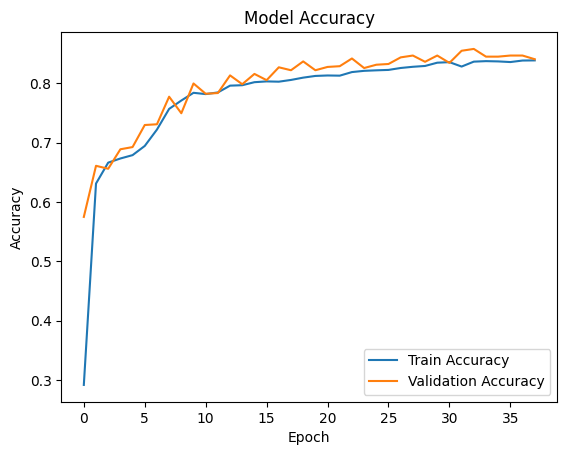

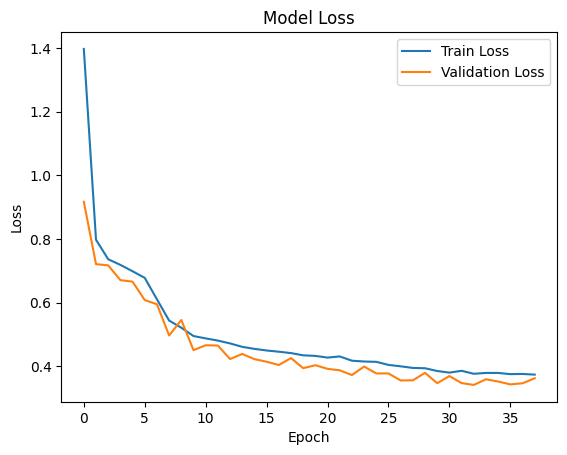

In [7]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


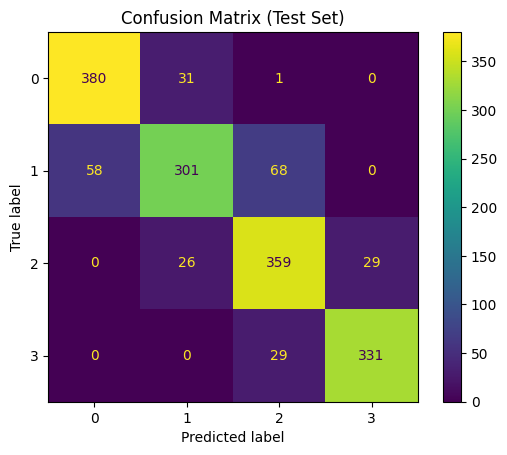

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(validate_x), axis=1)
y_true = np.argmax(validate_y.values, axis=1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix (Test Set)")
plt.show()


FIND A GOOD MODEL USING KERAS_TUNER

In [34]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers


In [32]:
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer (fixed 22 features)
    model.add(layers.Input(shape=(22,)))
    
    # Tune number of hidden layers: between 1 and 3
    for i in range(hp.Int('num_layers', 1, 3)):
        for activation in ['relu', 'tanh']:
            model.add(layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                activation = activation
            ))
            # Tune dropout rate per layer
            model.add(layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
            ))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Tune learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [35]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='tuner_results',
    project_name='dnn_tuning'
)


Reloading Tuner from tuner_results/dnn_tuning/tuner0.json


In [36]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_x, train_y,
    epochs=50,
    validation_data=(test_x, test_y),
    callbacks=[stop_early],
    verbose=1
)


LOAD OLD MODELS FROM ML FLOW

In [72]:

# To read models form ml flow. 
# Replace this with your run_id
run_id = "817eb2e782a341cbbb93e5694cc174be"

# Load the model back
loaded_model = mlflow.keras.load_model(f"runs:/{run_id}/keras_model")
results= loaded_model.evaluate(validate_x, validate_y, batch_size=128)
print("test loss, test acc:", results)

history_loaded_model = loaded_model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8500 - loss: 0.3524  
test loss, test acc: [0.3523799479007721, 0.8499690294265747]
Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8691 - loss: 0.3144 - val_accuracy: 0.8525 - val_loss: 0.3578
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8736 - loss: 0.3117 - val_accuracy: 0.8538 - val_loss: 0.3530
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8712 - loss: 0.3180 - val_accuracy: 0.8550 - val_loss: 0.3413
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.3110 - val_accuracy: 0.8550 - val_loss: 0.3626
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8740 - loss: 0.3114 - val_accuracy: 0.8538 - val_loss: 0.3552
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.3153 - val_accuracy: 0.8525 - val_loss: 0.3475
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8736 - loss: 0.3113 - val_acc

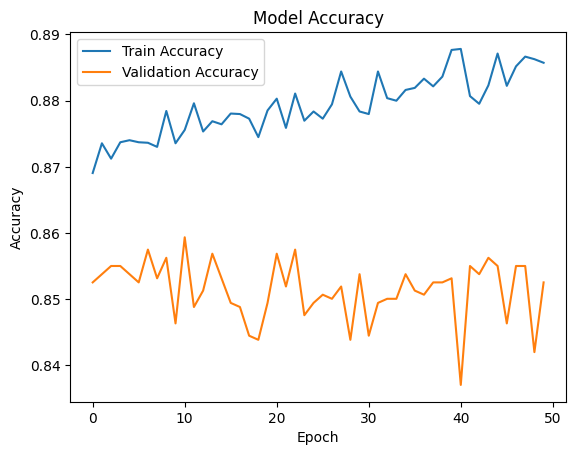

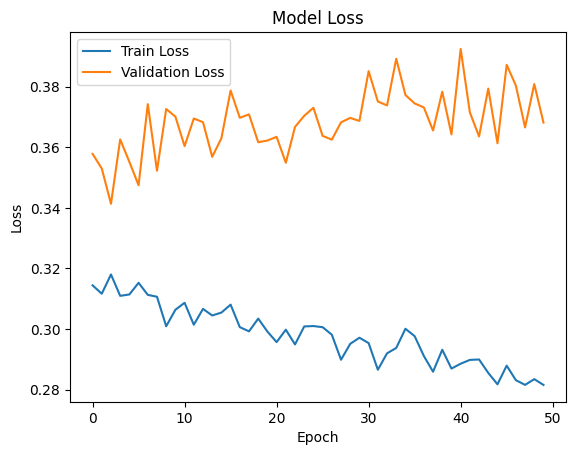

In [73]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_loaded_model.history['accuracy'], label='Train Accuracy')
plt.plot(history_loaded_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_loaded_model.history['loss'], label='Train Loss')
plt.plot(history_loaded_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#make notes on the model I just loaded from ml flow
mlflow.set_tag("notes", "Model reached 90% accuracy but shows signs of overfitting (val_loss increasing after epoch 8).")

In [ ]:
# predict on validation set
predictions = loaded_model.predict(validate_x)

from sklearn.metrics import accuracy_score, mean_squared_error

acc = accuracy_score(validate_y, predictions)
print(f"New Validation Accuracy: {acc:.4f}")

